In [8]:
import os

import numpy as np
import pandas as pd
import pyreadr

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from gglasso.helper.utils import sparsity, zero_replacement, normalize, log_transform
from gglasso.problem import glasso_problem

### Import preprocessed soil data

In [79]:
metadata['tot_org_carb'].unique()

array([ 30.3 ,  28.3 ,  68.9 ,  57.1 ,  28.2 ,  16.8 ,  29.9 ,  69.5 ,
        76.1 ,  22.1 ,  21.7 ,  24.4 ,   4.2 ,  14.2 ,  16.6 ,  42.5 ,
        39.8 ,  53.9 , 158.3 ,  70.2 ,  39.1 , 105.4 ,  56.7 ,  34.4 ,
        23.3 ,  22.7 ,  12.1 ,  17.1 ,  81.  ,   1.2 ,   5.7 ,  25.  ,
        22.9 ,  11.6 ,   8.5 ,  24.9 ,  15.9 ,   8.2 ,  18.1 , 134.2 ,
        57.4 , 130.9 ,  59.5 ,  93.6 ,  33.4 ,  63.8 ,  31.  ,  27.8 ,
        17.  ,  54.5 ,  14.6 ,  95.2 ,  64.4 ,  45.9 ,  33.  , 127.6 ,
        21.5 ,  16.7 ,  95.5 ,  26.5 ,  40.6 ,  43.3 ,  25.6 ,   6.9 ,
        27.  ,  40.7 ,  39.4 ,  37.5 ,  19.1 , 139.5 ,  41.1 ,  64.1 ,
        61.2 ,  98.7 , 107.  ,  63.1 ,   2.3 ,  52.2 ,  12.84,   3.  ,
       108.2 ,  11.4 , 158.8 , 182.4 ])

In [93]:
metadata.columns

Index(['BarcodeSequence', 'LinkerPrimerSequence', 'barcode_read_group_tag',
       'dna_extracted_prep', 'experiment_alias', 'experiment_center',
       'experiment_design_description', 'experiment_title', 'instrument_name',
       'key_seq', 'library_construction_protocol', 'linker', 'pcr_primers',
       'physical_specimen_remaining_prep', 'platform', 'pool_member_name',
       'pool_proportion', 'primer_read_group_tag', 'region', 'run_alias',
       'run_center', 'run_date', 'run_prefix', 'samp_size', 'sample_center',
       'sample_type_prep', 'sequencing_meth', 'study_center', 'study_ref',
       'target_gene', 'target_subfragment', 'altitude', 'annual_season_precpt',
       'annual_season_temp', 'anonymized_name', 'assigned_from_geo',
       'carb_nitro_ratio', 'cmin_rate', 'collection_date', 'common_name',
       'country', 'depth', 'dna_extracted', 'elevation', 'env_biome',
       'env_feature', 'env_matter', 'host_subject_id', 'latitude', 'longitude',
       'ph', 'physical_sp

In [92]:
metadata['depth']

#SampleID
103.BZ1    0-0.05
103.CR1    0-0.05
103.GB2    0-0.05
103.GB3    0-0.05
103.GB1    0-0.05
            ...  
103.SV1    0-0.05
103.HI4    0-0.05
103.HI1    0-0.05
103.HI2    0-0.05
103.HI3    0-0.05
Name: depth, Length: 89, dtype: object

In [73]:
metadata = pd.read_table('../data/soil/88soils_modified_metadata.txt', index_col=0)
metadata.columns

Index(['BarcodeSequence', 'LinkerPrimerSequence', 'barcode_read_group_tag',
       'dna_extracted_prep', 'experiment_alias', 'experiment_center',
       'experiment_design_description', 'experiment_title', 'instrument_name',
       'key_seq', 'library_construction_protocol', 'linker', 'pcr_primers',
       'physical_specimen_remaining_prep', 'platform', 'pool_member_name',
       'pool_proportion', 'primer_read_group_tag', 'region', 'run_alias',
       'run_center', 'run_date', 'run_prefix', 'samp_size', 'sample_center',
       'sample_type_prep', 'sequencing_meth', 'study_center', 'study_ref',
       'target_gene', 'target_subfragment', 'altitude', 'annual_season_precpt',
       'annual_season_temp', 'anonymized_name', 'assigned_from_geo',
       'carb_nitro_ratio', 'cmin_rate', 'collection_date', 'common_name',
       'country', 'depth', 'dna_extracted', 'elevation', 'env_biome',
       'env_feature', 'env_matter', 'host_subject_id', 'latitude', 'longitude',
       'ph', 'physical_sp

In [3]:
soil = pd.read_csv('../data/soil/soil_id_116.csv', sep=',', index_col = 0).T
soil.head()

,103.CA2,103.CO3,103.SR3,103.IE2,103.BP1,103.VC2,103.SA2,103.GB2,103.CO2,103.KP1,...,103.LQ1,103.HI1,103.RT1,103.HI2,103.DF1,103.CF3,103.AR1,103.TL1,103.HI4,103.BB1
1124701,16.0,15.0,2.0,9.0,14.0,8.0,7.0,4.0,3.0,3.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
697997,3.0,5.0,1.0,1.0,68.0,1.0,2.0,4.0,1.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
203969,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,3.0,7.0,1.0,1.0,1.0,1.0
205391,1.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,...,1.0,1.0,1.0,1.0,5.0,4.0,1.0,7.0,1.0,1.0
843189,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,5.0,1.0,2.0,2.0,1.0


In [4]:
ph = metadata["ph"]
ph = ph.reindex(soil.columns)
ph.head()

103.CA2    8.02
103.CO3    6.02
103.SR3    6.95
103.IE2    5.52
103.BP1    7.53
Name: ph, dtype: float64

In [5]:
#check if any ids are missing
assert not ph.isnull().values.any()

# assert that samples of ph and soil are identical
assert set(soil.columns) == set(ph.index)

### CLR-transformation of X

##### Dataframe `soil` need to be of shape (p,N) for normalizing to simplex + clr transform

In [6]:
soil.shape

(116, 89)

In [9]:
X = normalize(soil)
X.shape

(116, 89)

In [10]:
X = log_transform(X)
(p,N) = X.shape
(p,N)

(116, 89)

### Calculate covariance and scale to correlations

In [11]:
S0 = np.cov(X.values, bias = True)
# scale covariances to correlations
scale = np.tile(np.sqrt(np.diag(S0)),(S0.shape[0],1))
scale = scale.T * scale

S = S0 / scale
S.shape

(116, 116)

### GGLasso low-rank with lambda = 0.14447343, mu =  2.36, rank=6

In [12]:
P = glasso_problem(S, N, latent = True, do_scaling = False)

print(P)

lambda1_range = [0.14447343]
mu1_range = [2.36]


modelselect_params = {'lambda1_range': lambda1_range, 'mu1_range': mu1_range}

P.model_selection(modelselect_params = modelselect_params, method = 'eBIC', gamma = 0.25)

# regularization parameters are set to the best ones found during model selection
print(P.reg_params)

 
SINGLE GRAPHICAL LASSO PROBLEM WITH LATENT VARIABLES
Regularization parameters:
{'lambda1': 0.01, 'mu1': 0.1}
ADMM terminated after 109 iterations with status: optimal.
{'lambda1': 0.14447343, 'mu1': 2.36}


In [13]:
# gg_lowrank = pd.read_csv("~/Downloads/gglasso_lr.csv", sep=',', header=None)
gg_lowrank = P.solution.lowrank_
gg_lowrank.shape

(116, 116)

In [14]:
gg_rank = np.linalg.matrix_rank(gg_lowrank)
print('Rank of low-rank component: {0}'.format(gg_rank))

Rank of low-rank component: 6


### SE low-rank with lambda = 0.14447343, rank=6

In [17]:
SE_lowrank = pyreadr.read_r('SE_lowrank.rds')
SE_lowrank = SE_lowrank[None]
SE_lowrank = np.array(SE_lowrank)
SE_lowrank.shape

(116, 116)

In [18]:
se_rank = np.linalg.matrix_rank(SE_lowrank)
print('Rank of low-rank component: {0}'.format(se_rank))

Rank of low-rank component: 6


### Compare two solutions

In [19]:
np.allclose(SE_lowrank, gg_lowrank, atol=1e-01)

True

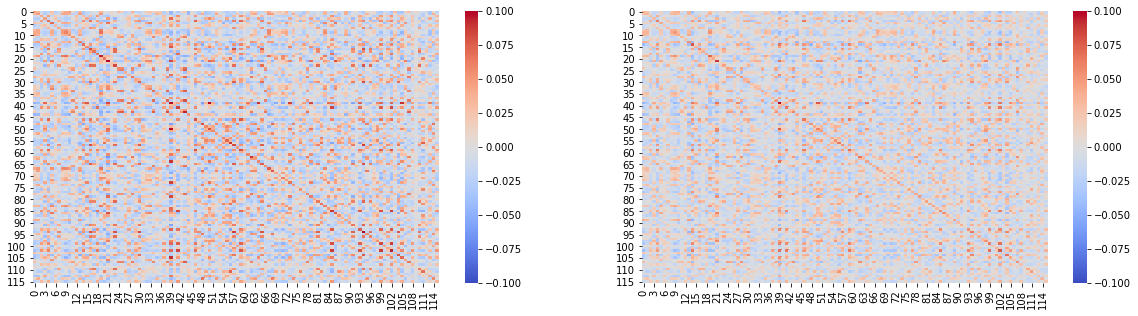

In [25]:
#plot sparsity
fig, axs = plt.subplots(1,2, figsize = (20,5))
sns.heatmap(SE_lowrank, ax = axs[0], cmap = "coolwarm", vmin = -0.1, vmax = 0.1)
sns.heatmap(gg_lowrank, ax = axs[1], cmap = "coolwarm", vmin = -0.1, vmax = 0.1)

### Robust PCA in [SE](https://github.com/zdk123/SpiecEasi/blob/ff528b23fafbd455efcca9dd356bef28951edf82/R/SparseLowRankICov.R)

In [ ]:
# robustPCA <- function(X, L, inverse=TRUE) {
#   Lsvd <- svd(L)
#   ind <- Lsvd$d>1e-9
#   if (inverse) {
#     loadings <- diag(sqrt(1/Lsvd$d[ind])) %*% t(Lsvd$v[,ind])
#   } else {
#     loadings <- diag(sqrt(Lsvd$d[ind])) %*% t(Lsvd$v[,ind])
#   }

#   scores <- X %*% t(loadings)
#   return(list(scores=scores, loadings=loadings))
# }

### Robust PCA in GGLasso

In [20]:
def robust_PCA(X, L, inverse=True):
    #SVD of low-rank component
    v_tilde, sigma, v_tilde_T  = np.linalg.svd(L, full_matrices=True)
    
    ind = np.argwhere(sigma > 1e-9)
    
    if inverse:
        loadings = np.diag(np.sqrt(1/sigma[ind]).reshape(len(ind),)) @ v_tilde[:, :len(ind)].T
    else:
        loadings = np.diag(np.sqrt(sigma[ind]).reshape(len(ind),)) @ v_tilde[:, :len(ind)].T
        
    zu = X.T @ loadings.T
    
    
    return zu, loadings

In [39]:
def robust_PCA(X, L, inverse=True):
    sig, V = np.linalg.eigh(L)
    ind = np.argwhere(sig > 1e-9)

    if inverse:
        loadings = V[:,ind] @ np.diag(np.sqrt(1/sig[ind]))
    else:
        loadings = V[:,ind] @ np.diag(np.sqrt(sig[ind]))

    zu = X.values.T @ loadings
    
    return zu, loadings

### Plot SE/pH correlation

In [24]:
zu_SE, se_loadings = robust_PCA(X, SE_lowrank, inverse=True)
zu_SE.shape

(89, 6)

In [43]:
test = pd.concat([zu_SE, ph.reindex(zu_SE.index)], axis=1)
test

,0,1,2,3,4,5,ph
103.CA2,-3.881230,1.473050,3.736846,-0.168383,-2.198682,0.146349,8.02
103.CO3,-3.854069,1.328352,0.760213,-0.465473,-3.420724,0.852506,6.02
103.SR3,-2.874836,0.401403,2.291766,0.783078,1.794675,0.128075,6.95
103.IE2,-0.964121,-1.206462,-5.766909,-1.822464,0.143857,-5.947853,5.52
103.BP1,-3.791169,0.938866,1.697224,-0.991540,-4.727427,1.037163,7.53
...,...,...,...,...,...,...,...
103.CF3,6.129408,-0.808688,2.185421,-1.854054,-1.770429,-4.195595,3.56
103.AR1,-1.210325,0.836794,-2.082505,-4.285733,-1.236090,0.906928,5.80
103.TL1,1.151785,-3.264641,0.649825,2.361556,-1.613714,-2.983102,4.58
103.HI4,3.678646,1.607667,-3.690162,0.761895,-0.319267,-1.515827,4.92


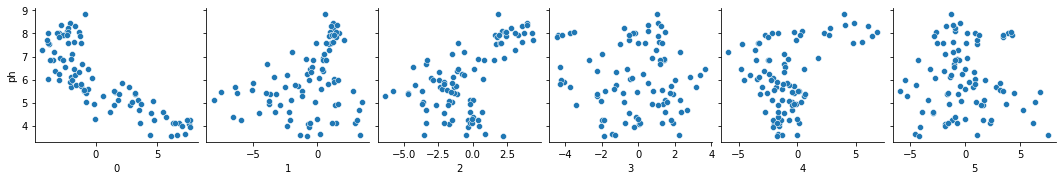

In [46]:
import seaborn as sns
sns.pairplot(test, y_vars="ph", x_vars=test.iloc[:, :-1].columns.values)

In [50]:
test = test.rename({0: 'PC1', 1: 'PC2',2: 'PC3',3: 'PC4',4: 'PC5',5: 'PC6'}, axis=1)

In [91]:
carb = metadata['tot_org_carb'].reindex(soil.columns)

In [94]:
import plotly.graph_objects as go

index_vals = carb.astype('category').cat.codes

fig = go.Figure(data=go.Splom(
                dimensions=[dict(label='PC1',
                                 values=test['PC1']),
                            dict(label='PC2',
                                 values=test['PC2']),
                            dict(label='PC3',
                                 values=test['PC3']),
                            dict(label='PC4',
                                 values=test['PC4']),
                           dict(label='PC5',
                                 values=test['PC5']),
                           dict(label='PC6',
                                 values=test['PC6']),
                           dict(label='ph',
                                 values=test['ph'])],
                diagonal_visible=False,
                showupperhalf=False,
                text=test['ph'],
                marker=dict(color=index_vals,
                            showscale=False, # colors encode categorical variables
                            line_color='blue', line_width=0.5)
                ))


fig.update_layout(
    title='Soil data',
    width=1000,
    height=1000,
)

fig.show()

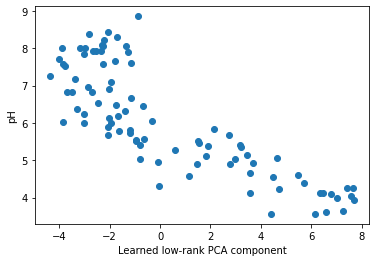

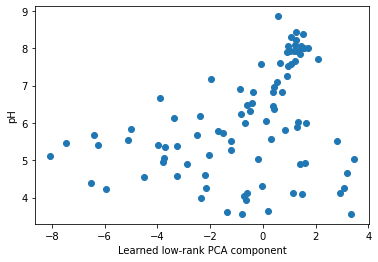

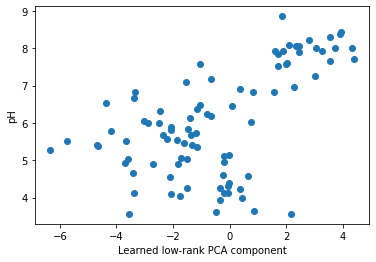

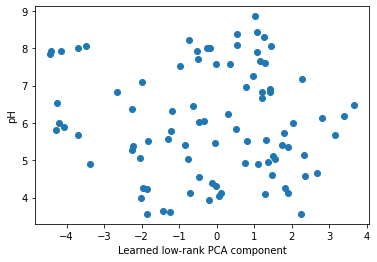

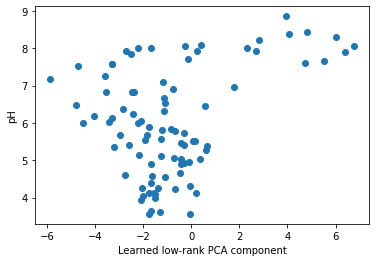

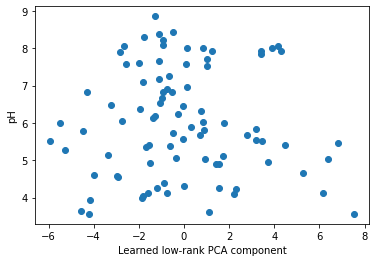

In [53]:
for i in range(0, se_rank):
    plt.scatter(zu_SE[i], ph)
    plt.xlabel("Learned low-rank PCA component")
    plt.ylabel("pH")
    plt.show()

In [30]:
for i in range(se_rank):
    print("Spearman correlation between pH and {0}th component: {1}, p-value: {2}".format(i+1, stats.spearmanr(ph, zu_SE[:,i])[0], 
                                                                              stats.spearmanr(ph, zu_SE[:,i])[1]))

Spearman correlation between pH and 1th component: 0.0018983247115662782, p-value: 0.9859135981722774
Spearman correlation between pH and 2th component: -0.15935712376915123, p-value: 0.13578575033505175
Spearman correlation between pH and 3th component: -0.06639028890361166, p-value: 0.5364743397578483
Spearman correlation between pH and 4th component: 0.5163783722134997, p-value: 2.2210548507455952e-07
Spearman correlation between pH and 5th component: 0.3452226921652863, p-value: 0.0009221236190699046
Spearman correlation between pH and 6th component: 0.8388467058405947, p-value: 1.0662353413227162e-24


### Plot GGLasso/pH correlation

In [31]:
zu_gg, gg_loadings = robust_PCA(X, gg_lowrank, inverse=True)

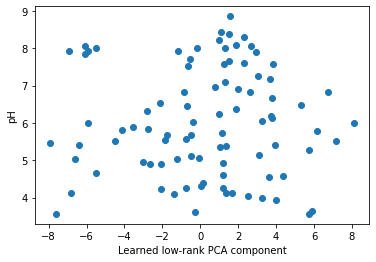

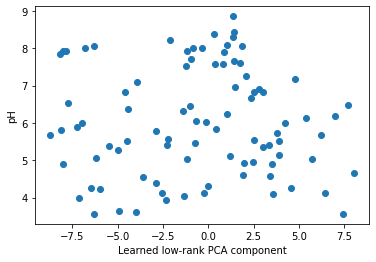

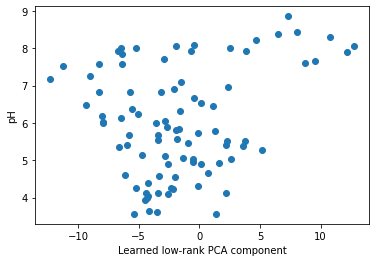

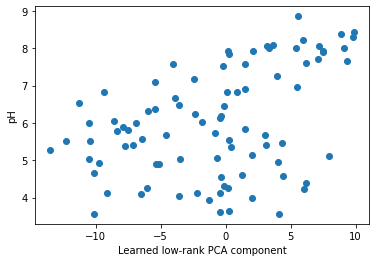

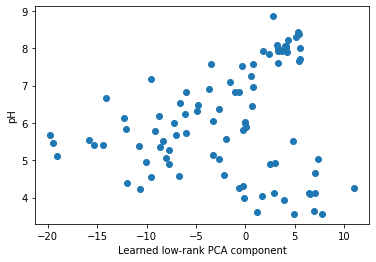

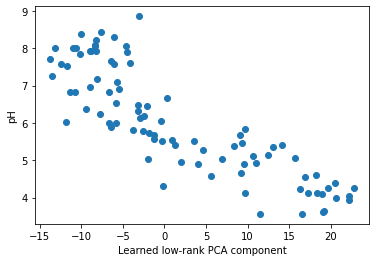

In [32]:
for i in range(gg_rank):
    plt.scatter(zu_gg[:,i], ph)
    plt.xlabel("Learned low-rank PCA component")
    plt.ylabel("pH")
    plt.show()

In [33]:
for i in range(0, se_rank):
    print("Spearman correlation between pH and {0}th component: {1}, p-value: {2}".format(i+1, stats.spearmanr(ph, zu_gg[:,i])[0], 
                                                                              stats.spearmanr(ph, zu_gg[:,i])[1]))

Spearman correlation between pH and 1th component: 0.0248314492539858, p-value: 0.8173276953312527
Spearman correlation between pH and 2th component: -0.020924135161569112, p-value: 0.8456836662703912
Spearman correlation between pH and 3th component: 0.1330019071457916, p-value: 0.2140416536199539
Spearman correlation between pH and 4th component: 0.4011168628206414, p-value: 9.797723427046136e-05
Spearman correlation between pH and 5th component: 0.13876498261543452, p-value: 0.1946709980922229
Spearman correlation between pH and 6th component: -0.874174273342837, p-value: 4.955025291593207e-29
